# 창원시 어린이 교통사고 예측모형

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import cross_val_score
from scipy.stats import skew

- 엑셀 상에서 필요없는 변수 제거 후 다시 로드

In [10]:
df = pd.read_csv('master_changwon_0927.csv')
df.head()

,acci_count,KSI,year,month,day,time,weekday,weekend,weather_sun,weather_rain,...,car_type8,car_type9,num_10,num_park,num_ele,num_academ,num_kinder,num_total,num_bus,ARI
0,5,2,2015,6,14,2,3,0,1.0,0.0,...,0.0,0.0,7.940228,1.0,1.0,29.0,1.0,9.607841,14.0,5.576923
1,2,1,2012,9,18,2,4,0,0.5,0.5,...,0.0,0.0,7.940228,1.0,1.0,29.0,1.0,9.607841,14.0,0.555556
2,2,0,2016,1,15,2,1,0,0.5,0.0,...,0.0,0.0,4.976734,0.0,3.0,0.0,2.0,8.402680,105.0,0.800000
3,2,0,2016,9,6,2,4,0,0.5,0.0,...,0.0,0.0,7.645876,3.0,1.0,18.0,1.0,9.928278,35.0,0.800000
4,1,1,2013,6,20,2,3,0,1.0,0.0,...,0.0,0.0,8.275886,1.0,4.0,108.0,4.0,10.389149,34.0,0.250000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   acci_count     90 non-null     int64  
 1   KSI            90 non-null     int64  
 2   year           90 non-null     int64  
 3   month          90 non-null     int64  
 4   day            90 non-null     int64  
 5   time           90 non-null     int64  
 6   weekday        90 non-null     int64  
 7   weekend        90 non-null     int64  
 8   weather_sun    90 non-null     float64
 9   weather_rain   90 non-null     float64
 10  weather_cloud  90 non-null     float64
 11  car_type1      90 non-null     float64
 12  car_type2      90 non-null     float64
 13  car_type3      90 non-null     float64
 14  car_type4      90 non-null     float64
 15  car_type5      90 non-null     float64
 16  car_type6      90 non-null     float64
 17  car_type7      90 non-null     float64
 18  car_type8   

### 모델1) 종속변수: KSI

In [33]:
#분석에 필요없는 변수 제거
none_col= ['acci_count','day','weekday','ARI','month','year']
df2 = df.drop(none_col, axis = 'columns')
df2.shape

(90, 22)

In [34]:
df2.columns

Index(['KSI', 'time', 'weekend', 'weather_sun', 'weather_rain',
       'weather_cloud', 'car_type1', 'car_type2', 'car_type3', 'car_type4',
       'car_type5', 'car_type6', 'car_type7', 'car_type8', 'car_type9',
       'num_10', 'num_park', 'num_ele', 'num_academ', 'num_kinder',
       'num_total', 'num_bus'],
      dtype='object')

In [36]:
# One Hot Encoding
df2 = pd.get_dummies(df2, columns=['time'])

In [37]:
data = df2.drop('KSI', axis = 'columns')
label = df2['KSI']

<AxesSubplot:>

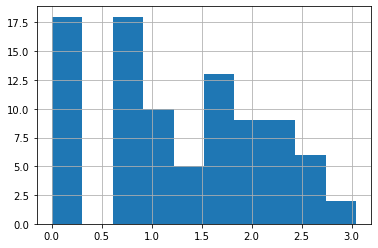

In [38]:
log_label = np.log1p(label)
log_label.hist()

In [39]:
#데이터 셋 분리 
X_train, X_test, y_train, y_test = train_test_split(data, log_label, test_size = 0.2, random_state=11)

In [40]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 0.428, RMSE: 10568577.092, MAE: 2491038.120


In [41]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

    real_count  predicted_count          diff
10    2.302585      -44838673.0  4.483868e+07
17    1.945910              4.0  2.054090e+00
13    1.791759              3.0  1.208241e+00
12    0.000000              1.0  1.000000e+00
2     0.000000              1.0  1.000000e+00


In [42]:
# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# model 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

### LinearRegression ###
RMSLE: inf, RMSE: 7.647, MAE: 3.992
### Ridge ###
RMSLE: 0.738, RMSE: 2.402, MAE: 1.899
### Lasso ###
RMSLE: 0.751, RMSE: 2.414, MAE: 1.931


In [43]:
# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.560, RMSE: 2.128, MAE: 1.640
### GradientBoostingRegressor ###
RMSLE: 0.536, RMSE: 2.866, MAE: 1.848
### XGBRegressor ###
RMSLE: 0.491, RMSE: 1.747, MAE: 1.418
### LGBMRegressor ###
RMSLE: 0.666, RMSE: 2.395, MAE: 1.933


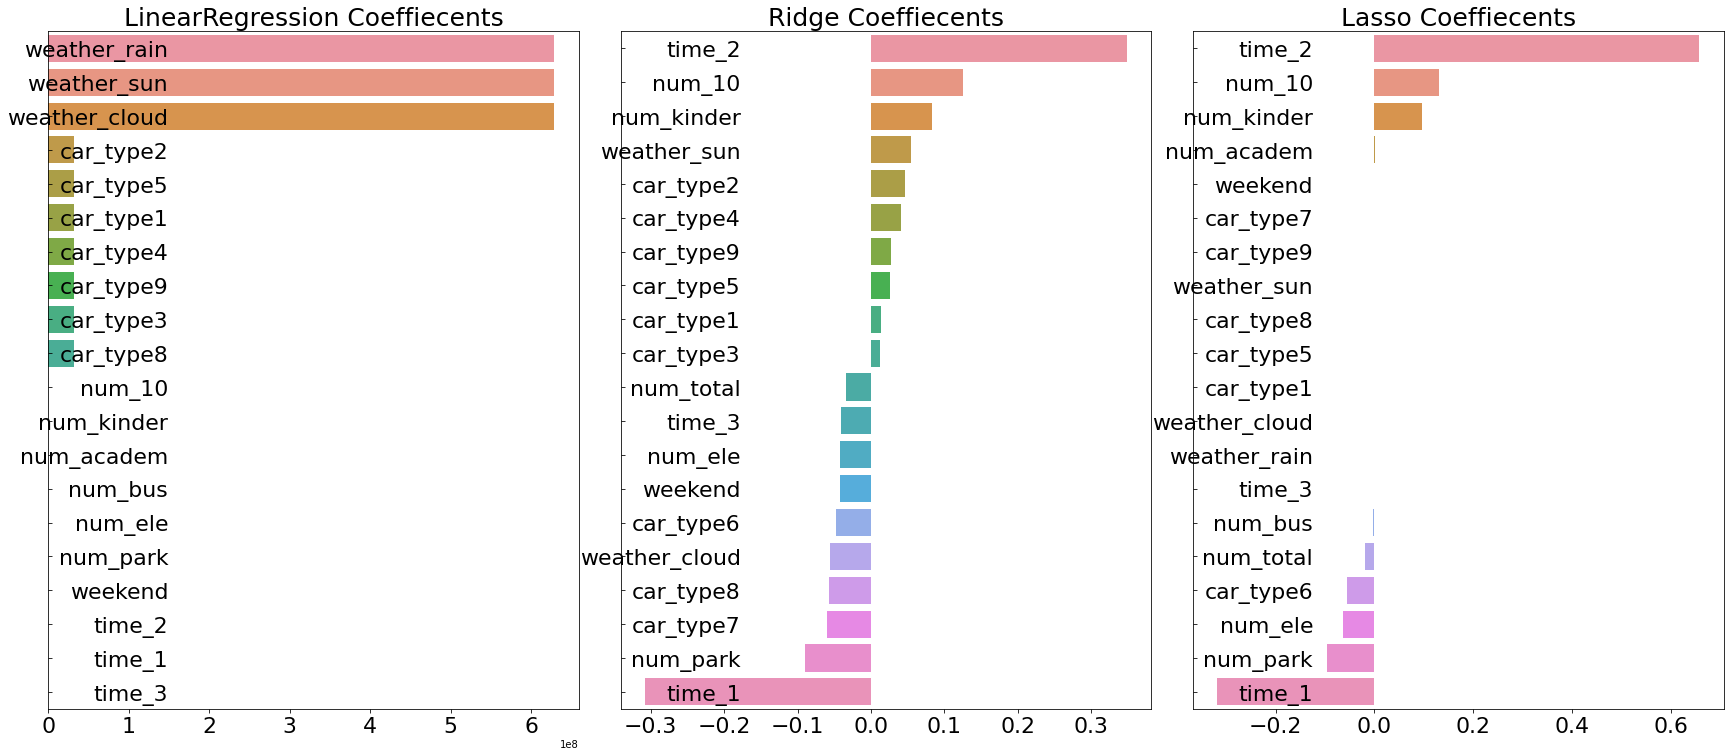

In [44]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명. 
    coef = pd.Series(model.coef_, index=data.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화. 
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합. 
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.    
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [45]:
def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, data, log_label,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력           
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [5.18100000e+00 1.58508716e+07 1.06100000e+00 1.17200000e+00
 9.01000000e-01]
LinearRegression CV 평균 RMSE 값: 3170175.978

Ridge CV RMSE 값 리스트: [0.588 0.842 0.876 0.881 0.844]
Ridge CV 평균 RMSE 값: 0.806

Lasso CV RMSE 값 리스트: [0.656 0.885 0.848 0.939 0.81 ]
Lasso CV 평균 RMSE 값: 0.828


In [46]:
#하이퍼 파라미터 튜닝
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(data, log_label)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.8117, 최적 alpha:{'alpha': 15}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.79, 최적 alpha:{'alpha': 0.03}


In [51]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

LinearRegression 로그 변환된 RMSE: 0.587
Ridge 로그 변환된 RMSE: 0.677
Lasso 로그 변환된 RMSE: 0.684


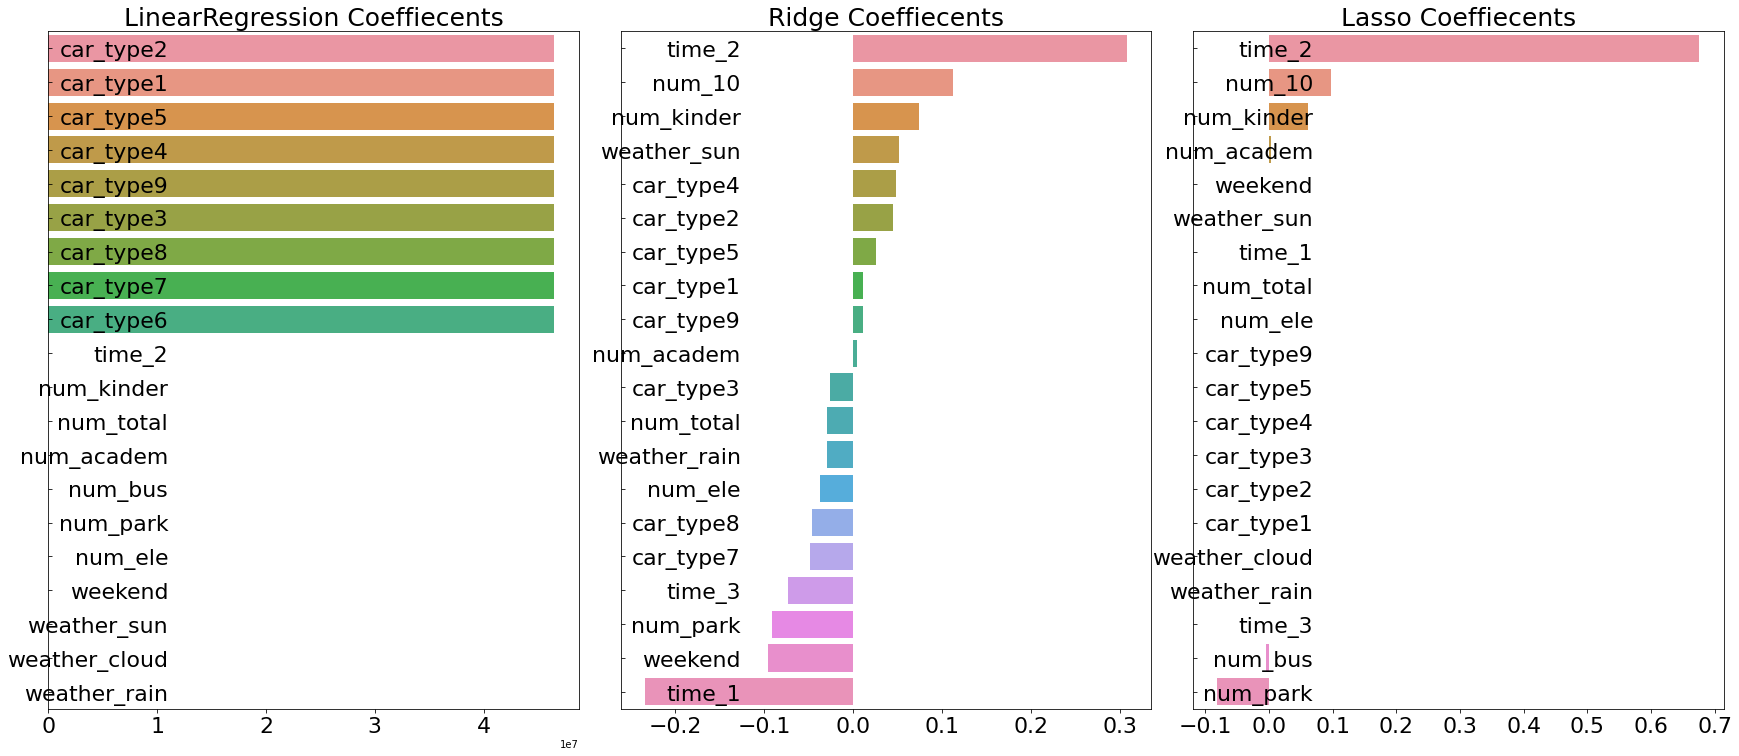

In [52]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(data, log_label)
ridge_reg = Ridge(alpha=15)
ridge_reg.fit(data, log_label)
lasso_reg = Lasso(alpha=0.03)
lasso_reg.fit(data, log_label)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [48]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

# 회귀 트리 학습/예측/평가

In [53]:
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.5977, 최적 alpha:{'n_estimators': 1000}


In [54]:
lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.6044, 최적 alpha:{'n_estimators': 1000}


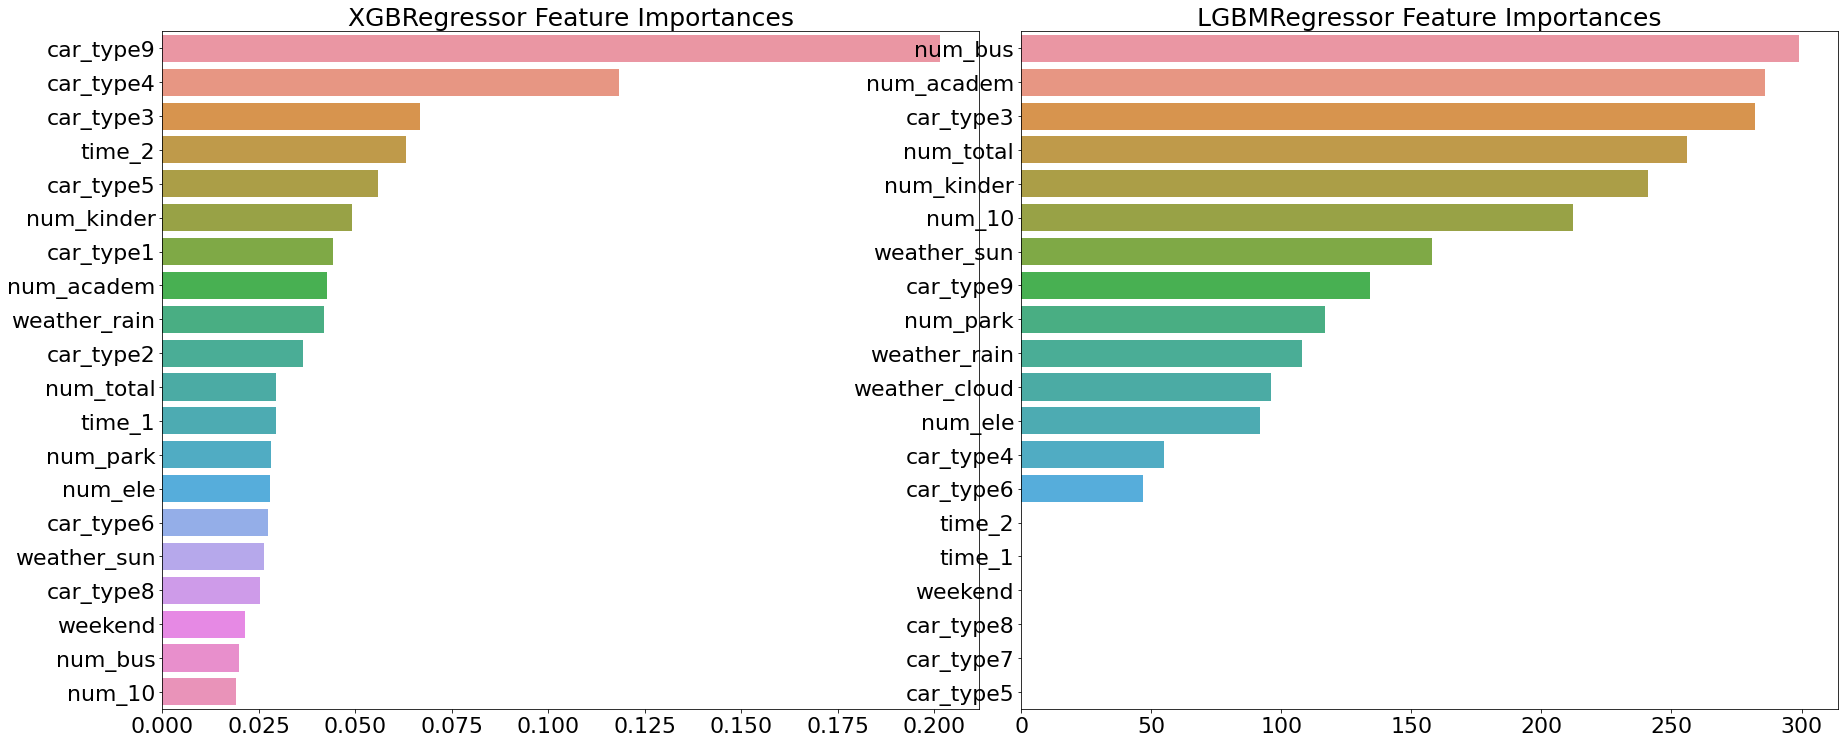

In [56]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=data.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

# 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [71]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.6 * ridge_pred + 0.4 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.6993121950522984
Ridge 모델의 RMSE: 0.7383096884569149
Lasso 모델의 RMSE: 0.7579636376214657


In [ ]:
Ridge 로그 변환된 RMSE: 0.677
Lasso 로그 변환된 RMSE: 0.684
XGBRegressor RMSE 값: 0.5977
LGBMRegressor RMSE 값: 0.6044

- 제일 우리가 원하는 건 LGBMRegressor RMSE 값!인데...

### 모델2) 종속변수: acci_count

In [76]:
#분석에 필요없는 변수 제거
none_col= ['KSI','day','weekday','ARI','month','year']
df3 = df.drop(none_col, axis = 'columns')
df3.shape

(90, 22)

In [77]:
df3.columns

Index(['acci_count', 'time', 'weekend', 'weather_sun', 'weather_rain',
       'weather_cloud', 'car_type1', 'car_type2', 'car_type3', 'car_type4',
       'car_type5', 'car_type6', 'car_type7', 'car_type8', 'car_type9',
       'num_10', 'num_park', 'num_ele', 'num_academ', 'num_kinder',
       'num_total', 'num_bus'],
      dtype='object')

In [78]:
# One Hot Encoding
df3 = pd.get_dummies(df3, columns=['time'])

In [79]:
data = df3.drop('acci_count', axis = 'columns')
label = df3['acci_count']

<AxesSubplot:>

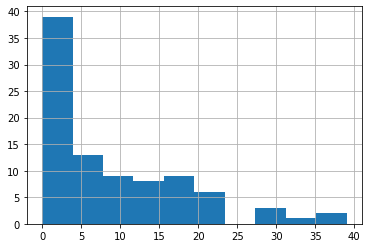

In [80]:
df3['acci_count'].hist()

<AxesSubplot:>

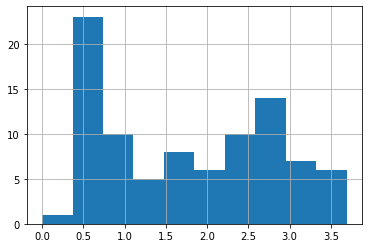

In [81]:
log_label = np.log1p(label)
log_label.hist()

In [82]:
#데이터 셋 분리 
X_train, X_test, y_train, y_test = train_test_split(data, log_label, test_size = 0.2, random_state=11)

In [83]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MAE 는 scikit learn의 mean_absolute_error() 로 계산
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))
    
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 0.352, RMSE: 15506663.403, MAE: 3654956.292


In [84]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측 값을 서로 비교 할 수 있도록 생성. 
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']= np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력. 
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(y_test,pred,n_tops=5)

    real_count  predicted_count          diff
10    2.708050      -65789198.0  6.578920e+07
9     0.000000              2.0  2.000000e+00
17    2.564949              4.0  1.435051e+00
8     0.693147              2.0  1.306853e+00
13    2.833213              4.0  1.166787e+00


In [85]:
#하이퍼 파라미터 튜닝
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(data, log_label)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.8777, 최적 alpha:{'alpha': 15}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.8542, 최적 alpha:{'alpha': 0.03}


LinearRegression 로그 변환된 RMSE: 0.634
Ridge 로그 변환된 RMSE: 0.724
Lasso 로그 변환된 RMSE: 0.75


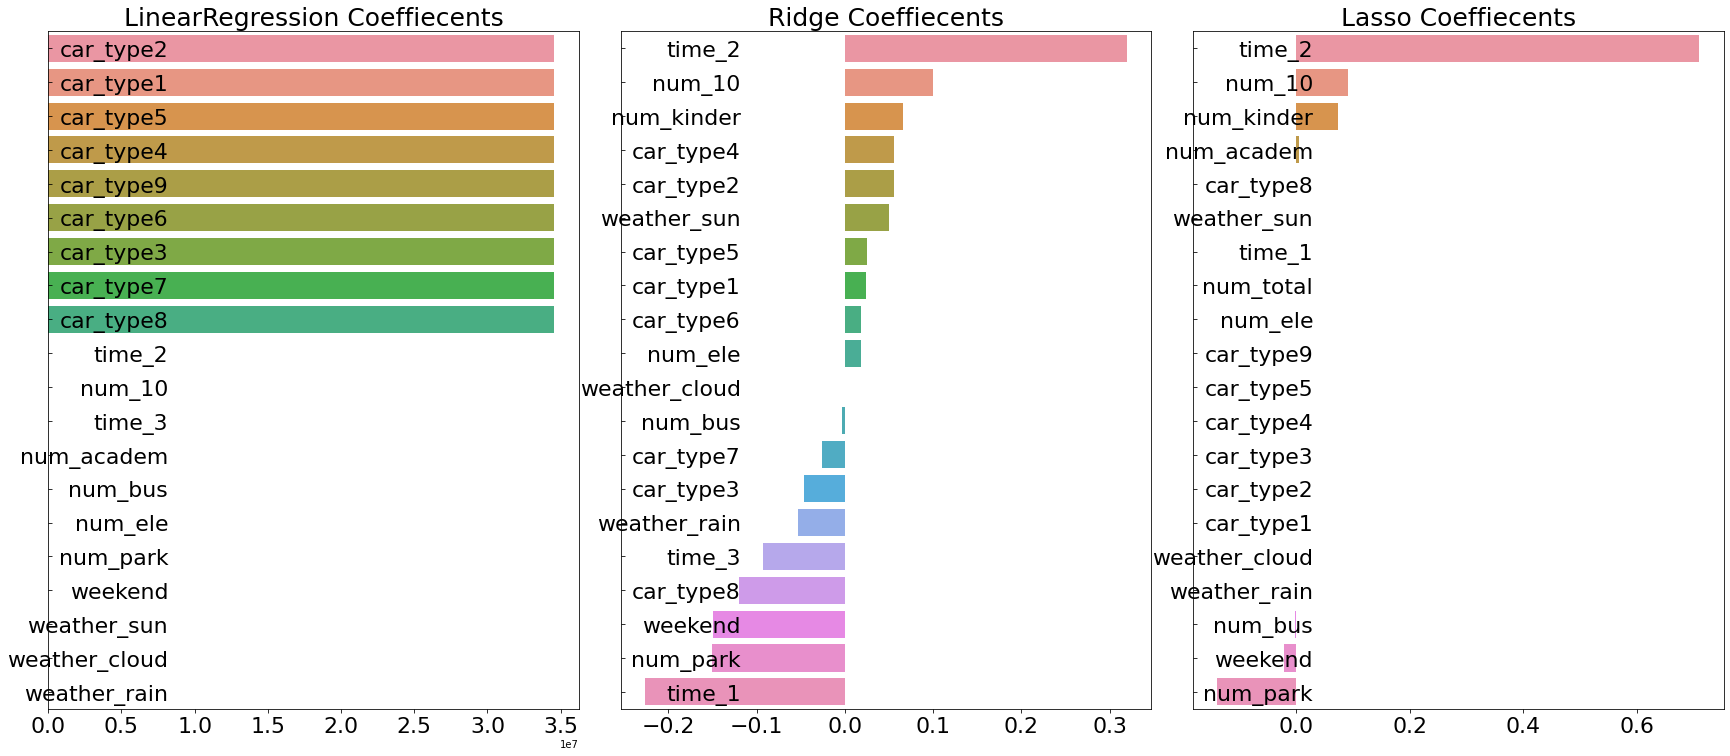

In [86]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(data, log_label)
ridge_reg = Ridge(alpha=15)
ridge_reg.fit(data, log_label)
lasso_reg = Lasso(alpha=0.03)
lasso_reg.fit(data, log_label)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [87]:
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.5397, 최적 alpha:{'n_estimators': 1000}


In [88]:
lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.5802, 최적 alpha:{'n_estimators': 1000}


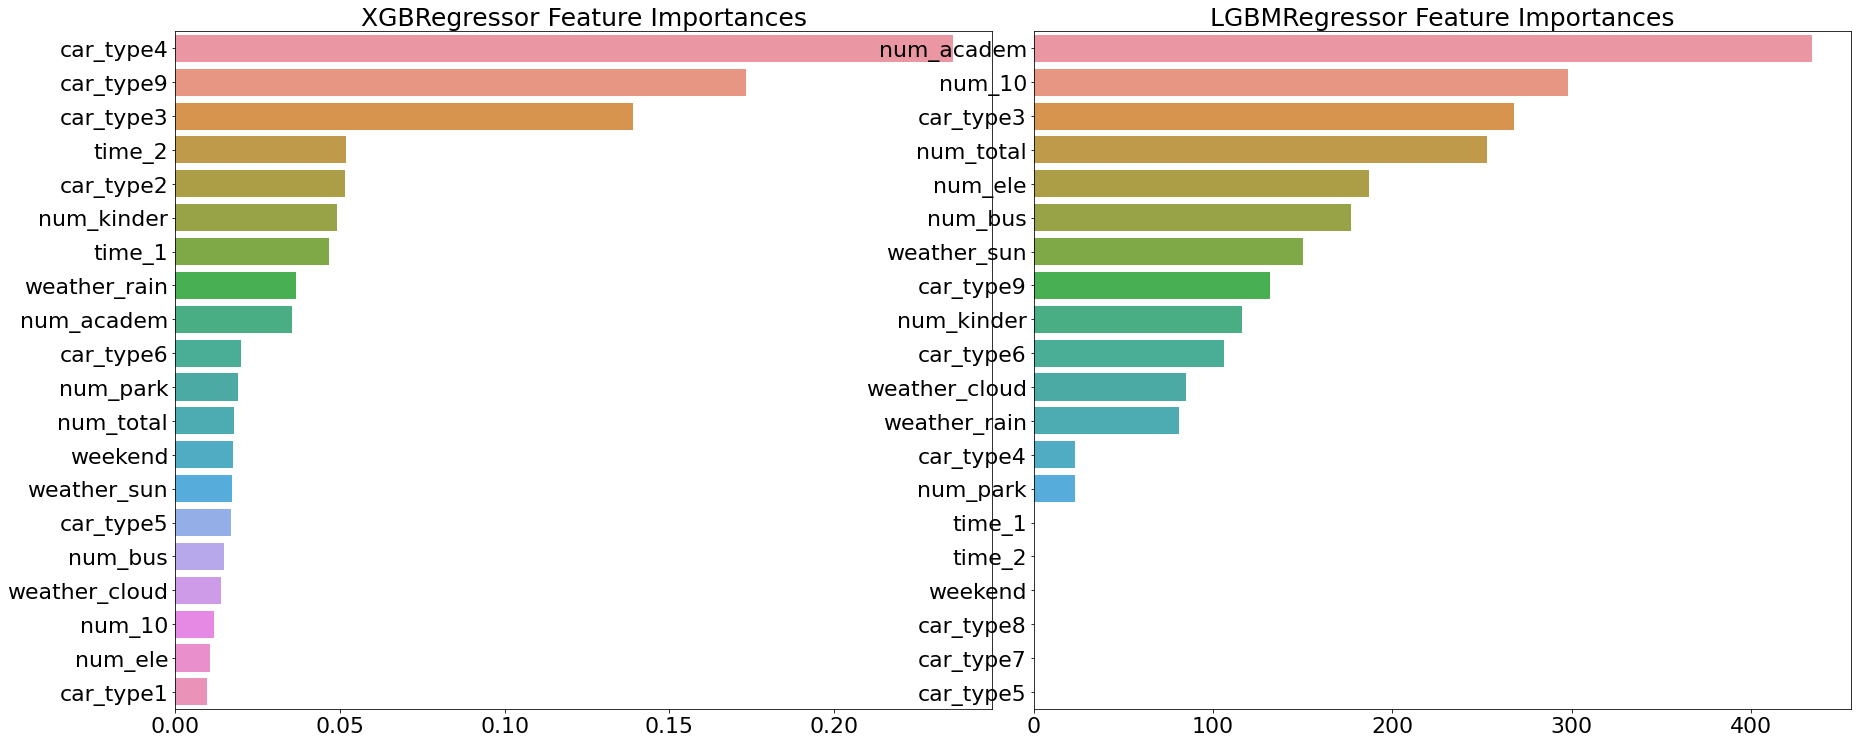

In [89]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=data.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

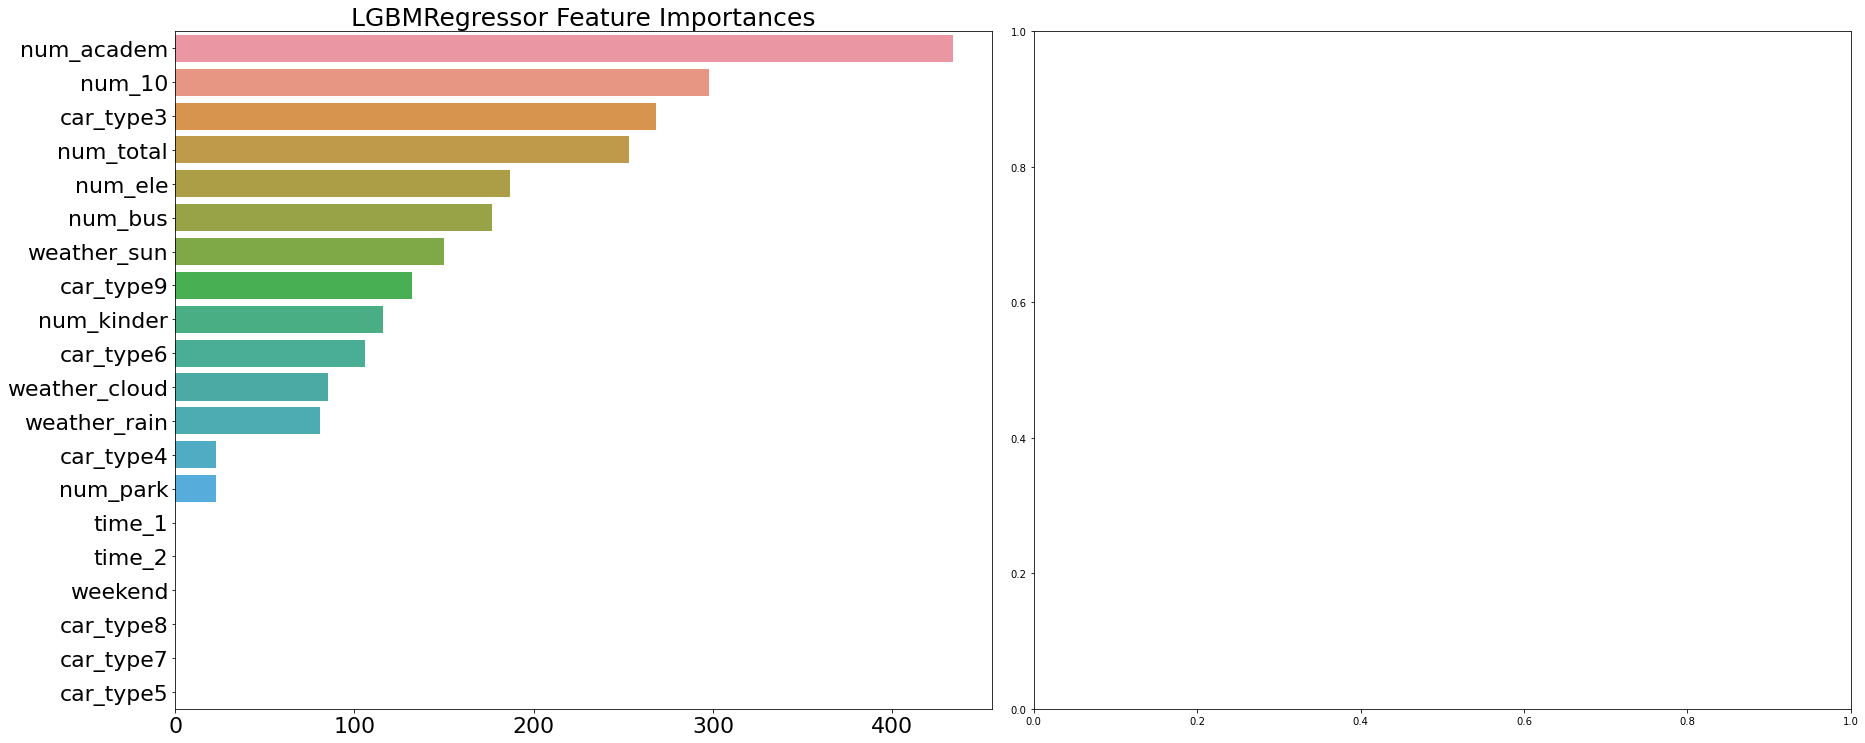

In [91]:
models = [best_lgbm]
visualize_ftr_importances(models)

# 상관계수 도출

Text(0.5, 1.0, 'Correlation_matrix')

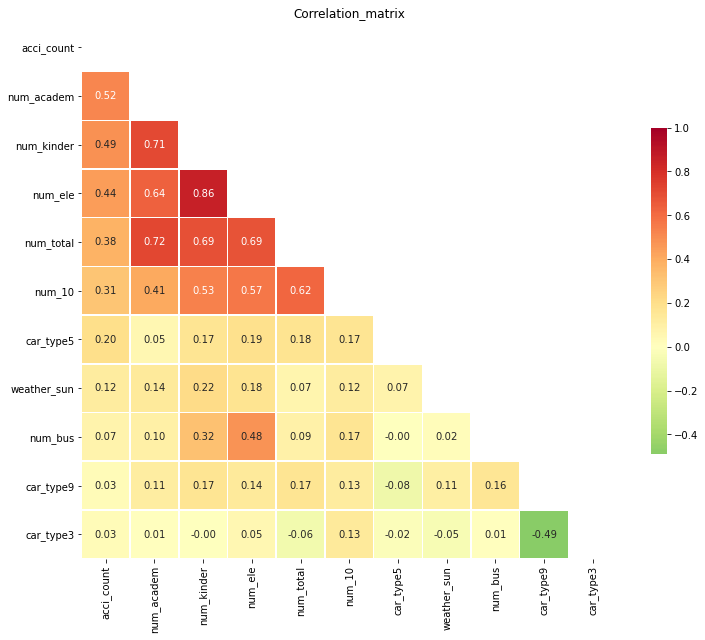

In [105]:
# 상관관계를 탐색할 변수 선택
numerics = ['num_academ','num_10','car_type3','num_total','num_ele','num_bus','weather_sun',
            'car_type9','num_kinder','car_type5','acci_count']
regular_temp = df[numerics].copy()

# 상관관계 도출
corr_matrix = regular_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'acci_count', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation_matrix")

# 비교용 추가모델 학습

In [109]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state = 1217)
#모델 학습
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
evaluate_regr(y_test ,pred)

RMSLE: 0.248, RMSE: 0.485, MAE: 0.408


In [113]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=11)
elastic_net.fit(X_train, y_train)
pred = elastic_net.predict(X_test)
evaluate_regr(y_test ,pred)

RMSLE: 0.379, RMSE: 0.811, MAE: 0.678
